# Beam Element - This notebook computes the mass-matrix and body-forces for later use

In [1]:
import numpy as np
import scipy as sp
import sympy as sym
import pickle

from scipy import linalg
from sympy import mpmath
from sympy import cos, sin
from sympy import lambdify

from IPython.display import display
from __future__ import division
from sympy.interactive import printing
printing.init_printing(use_latex=True)
np.set_printoptions(precision=4,suppress=True)
from sympy.interactive import printing


import matplotlib.pyplot as plt
%matplotlib inline

#### Define Needed Functions

In [2]:
def Skew_sym(v):
    """
    This function returns the skew symetric matrix 
    of the angular velocity vector for a 2D problem
    """
    v_matrix = sym.Matrix([[  0 , -v[2]],
                          [v[2],     0]])
    return v_matrix

In [3]:
def Axial_sym(A):
    '''
    This funtcion returns the vector of the skew-symmectric matrix in 2D
    '''
    a_vec = 1/2*sym.Matrix([A[1,0] - A[0,1]])
    return a_vec

In [4]:
def Rotate_sym(theta):
    """
    This function returns the symbolic rotation matrix 
    for the simple 2D-rotation about the third axis
    """
    R = sym.Matrix([[sym.cos(theta),-sym.sin(theta)],
                    [sym.sin(theta), sym.cos(theta)]])
    return R

#### Define symbolic quantites


H = 


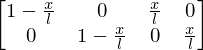

In [5]:
# symbolic system parameters 
E, G, I, A, rho, x, l, r, g, m, a, b, c, pi, phi  \
= sym.symbols('E G I A rho x l r g m a b c pi phi')

theta = sym.Matrix(['theta_1','theta_2'])
theta_dot = sym.Matrix(['thetadot_1','thetadot_2'])
theta_ddot = sym.Matrix(['thetaddot_1','thetaddot_2'])
omega = sym.Matrix(['omega_1','omega_2'])
alpha = sym.Matrix(['alpha_1','alpha_2'])

# Symbolic constraint forces and moments at the handles
f1c = sym.Matrix(['f_1_1','f_1_2'])
f2c = sym.Matrix(['f_2_1','f_2_2'])
tau1c = sym.Matrix(['tau_1'])
tau2c = sym.Matrix(['tau_2'])

# coordinates of the point in the 2D cross-section
# of nodes one and two 
s = sym.Matrix(['r_1','r_2']) 
s[0] = 0

# generalized coordinates
# one rotation and two displacements per-node (two nodes per element)
# in this version generalzied speeds are NOT ALWAYS qdots
q = sym.Matrix(sym.symarray('q',6))
qdot = sym.Matrix(sym.symarray('qdot',len(q)))
qddot = sym.Matrix(sym.symarray('qddot',len(q)))

# Deformations of Nodes (u's are not generalized speeds) 
delta = sym.Matrix([q[1:3,0], q[4:6,0]])
deltadot = sym.Matrix([qdot[1:3,0], qdot[4:8,0]])
deltaddot = sym.Matrix([qddot[1:3,0], qddot[4:6,0]])

# display([q,qdot,qddot])
# display([u,udot,uddot])


# Define shape function for element with one node at each end
h = sym.symarray('h', 2)
h[0] = (1 - x/l)
h[1] = (x/l)
# h[0] = sym.Rational(1,2)*(1-x)
# h[1] = sym.Rational(1,2)*(1+x)


# Compute shape function matrix
H = sym.Matrix([h[0]*sym.eye(2), h[1]*sym.eye(2)]).T
dHdx = H.diff(x)
print('\nH = ')
display(H)

### Needed Matrix Quantities

In [6]:
# Rotation Matricies for each node
R1 = Rotate_sym(theta[0])
R2 = Rotate_sym(theta[1])

# Angular Velocities and Accelerations are trivial for the 2D case
# For each node
omega1_skew = Skew_sym([0,0,omega[0]])
omega2_skew = Skew_sym([0,0,omega[1]])
alpha1_skew = Skew_sym([0,0,alpha[0]])
alpha2_skew = Skew_sym([0,0,alpha[1]])

R_interp = H*sym.Matrix.vstack(R1,R2)

### Define Kinematics


vp = 


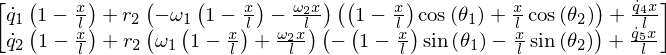


ap = 


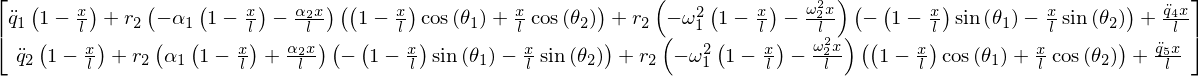

In [7]:
# Define velocity of generic point on element and handles
vP = H*deltadot + H*sym.Matrix.vstack(omega1_skew,omega2_skew)*R_interp*s
print('\nvp = ')
display(vP)
v1 = H.subs(x,0)*deltadot
# print('\nv1 = ')
# display(v1)
v2 = H.subs(x,l)*deltadot
# print('\nv2 = ')
# display(v2)

# Angular velocites of the cross-sections of the nodes
omega1 = sym.Matrix([omega[0]])
omega2 = sym.Matrix([omega[1]])

# Create 'Spatial' velocities for the nodes (useful for constraint force coefficient matrix)
V1 = sym.Matrix.vstack(omega1,v1)
V2 = sym.Matrix.vstack(omega2,v2)

# Define acceleration of generic point on element
aP = H*deltaddot + H*sym.Matrix.vstack(alpha1_skew,alpha2_skew)*R_interp*s + \
               H*sym.Matrix.vstack(omega1_skew*omega1_skew,omega2_skew*omega2_skew)*R_interp*s
print('\nap = ')
display(aP)

### Compute Partial Velocities

In [8]:
# generalized speeds need to be omega_i not qdot_i 
gen_speed = sym.Matrix.vstack(sym.Matrix.vstack(sym.Matrix([omega[0]]), sym.Matrix(qdot[1:3])), 
    sym.Matrix.vstack(sym.Matrix([omega[1]]), sym.Matrix(qdot[4:6])))

# Compute partial velocities of point 'P' and the nodes
VrP = [sym.Matrix([sym.diff(v,u) for v in vP]) for u in gen_speed]
# print('\nVrP = ')
# display(VrP)
Vr1 = [sym.Matrix([sym.diff(v,u) for v in V1]) for u in gen_speed]
# print('\nVr1 = ')
# display(Vr1)
Vr2 = [sym.Matrix([sym.diff(v,u) for v in V2]) for u in gen_speed]
# print('\nVr2 = ')
# display(Vr2)
# Wr1 = [sym.Matrix([sym.diff(w,u) for w in omega1]) for u in gen_speed]
# # print('\nWr1 = ')
# # display(Wr1)
# Wr2 = [sym.Matrix([sym.diff(w,u) for w in omega2]) for u in gen_speed]
# print('\nWr2 = ')
# display(Wr2)

### Compute the Mass Matrix

In [9]:
gen_accel = sym.Matrix.vstack(sym.Matrix.vstack(sym.Matrix([alpha[0]]), sym.Matrix(qddot[1:3])), 
    sym.Matrix.vstack(sym.Matrix([alpha[1]]), sym.Matrix(qddot[4:6])))

RHS = sym.Matrix([sym.integrate(2*pi*s[1]*rho*vr.dot(aP), ('r_2',0,r), (x,0,l)) for vr in VrP])
# Compute mass matrix
M = sym.Matrix([[sym.simplify(sym.expand(rhs).coeff(uddot)) for uddot in gen_accel] for rhs in RHS])
RHS = sym.simplify(RHS - M*gen_accel)

### Compute Internal forces 

#### 1. Transverse (Bending) Strain

In [10]:
# Orthogonal Matricies Not Extracted to Simplify Algebra
dT = sym.simplify(H.diff(x)*sym.Matrix([R1,R2]))
kappa = sym.simplify(sym.Matrix([Axial_sym(dT*R_interp.T),'0','0','0']))
# display(kappa)

#### 2. Longitudinal (Axial) Strian

In [11]:
# Define Locations of Centroid as a function of beam axis coordinate
x0_B = sym.Matrix(['x','0'])
# Convert to the newtonian basis
x0 = R_interp*x0_B

# Define Newtonian Unit Vector x-dir
n1 = sym.Matrix(['1','0'])

# strain = du/dx
# Derivatives w.r.t longitudinal beam coordinate
d_delta = dHdx*delta
dx0 = x0.diff(x)

# Compute axial strain in 'N'
epsilon = dx0 + d_delta - R_interp*n1

In [12]:
# epsilon

#### 3. Compute Internal Forces $Q_e = -\frac{\partial U}{\partial e}$

In [13]:
"""
Note: Sympy bug! Integrating a matrix returns a vector!!!
"""
# Transverse strain energy
kappa_squared = (kappa.T*dHdx.T).dot(dHdx*kappa)
Ut = 1/2*sym.integrate(E*I*kappa_squared, (x,0,l))

In [14]:
G = E/2.6
C = sym.Matrix([[E*A, 0],[0, 5/6*G*A]])
Ul = 1/2*sym.integrate(epsilon.T*R_interp*C*R_interp.T*epsilon, (x,0,l))[0]

In [15]:
# Compute Total Energy
U = Ul + Ut

# Compute Internal Force Vector
gen_coords = sym.Matrix.vstack(sym.Matrix.vstack(sym.Matrix([theta[0]]), sym.Matrix(q[1:3])), 
    sym.Matrix.vstack(sym.Matrix([theta[1]]), sym.Matrix(q[4:6])))
Qe = sym.Matrix([-U.diff(qi) for qi in gen_coords])

### Applied and body force vector

In [16]:
# Applied forces
# Gravity body force
fg = g*rho*sym.Matrix([0,-1])

# Compute beta
beta = sym.Matrix([sym.simplify(sym.integrate(vr.dot(fg),('r_2',-r,r),(x,0,l))) for vr in VrP]) + Qe + RHS
Fg = sym.Matrix([sym.simplify(sym.integrate(vr.dot(fg),('r_2',-r,r),(x,0,l))) for vr in VrP])

### Compute Constraint Force Coefficient Matricies

In [51]:
# Define vector from P to H1 and P to H2
rP1 = -s - x0
# display(rP1)
rP2 = -s + R_interp*sym.Matrix([l,0])-x0
# display(rP2)

# Adjust constraint torque to translate constraint forces to P
# in 3D this would be FjcP = SjP*Fjc
tau1cP = tau1c + sym.Matrix([sym.expand(rho*sym.integrate(-rP1[1]*f1c[0] + rP1[0]*f1c[1], ('r_2',-r,r), (x,0,l)))])
tau2cP = tau2c + sym.Matrix([sym.expand(rho*sym.integrate(-rP2[1]*f2c[0] + rP2[0]*f2c[1], ('r_2',-r,r), (x,0,l)))])

F1c = sym.Matrix.vstack(tau1c,f1c)
F2c = sym.Matrix.vstack(tau2c,f2c)

F1cP = sym.Matrix.vstack(tau1cP,f1c)
F2cP = sym.Matrix.vstack(tau2cP,f2c)
Gamma1 = sym.Matrix([[sym.expand(vr.dot(F1cP)).coeff(f) for f in F1c] for vr in Vr1])
Gamma2 = sym.Matrix([[sym.expand(vr.dot(F2cP)).coeff(f) for f in F2c] for vr in Vr2])

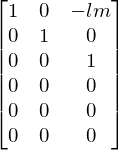

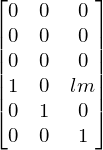

In [52]:
display(Gamma1.subs([(theta[0],0),(theta[1],0),(rho*r*l,m)]))
display(Gamma2.subs([(theta[0],0),(theta[1],0),(rho*r*l,m)]))

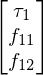

In [50]:
F1c

### Output

In [19]:
pickle.dump( M,      open( "gebf-mass-matrix.dump",   "wb" ) )
pickle.dump( beta,   open( "gebf-force-vector.dump",  "wb" ) )
pickle.dump( Gamma1, open( "gebf-1c-matrix.dump",     "wb" ) )
pickle.dump( Gamma2, open( "gebf-2c-matrix.dump",     "wb" ) )
# pickle.dump( U,      open( "gebf-strain-energy.dump", "wb" ) )
# # pickle.dump(PE, open("potential_enrgy", "wb")) 

In [20]:
M_func      = lambdify((E, A, I, r, rho, l, g, pi, q, theta, omega),      M, "numpy")
beta_func   = lambdify((E, A, I, r, rho, l, g, pi, q, theta, omega),   beta, "numpy")
Gamma1_func = lambdify((E, A, I, r, rho, l, g, pi, q, theta, omega), Gamma1, "numpy")
Gamma2_func = lambdify((E, A, I, r, rho, l, g, pi, q, theta, omega), Gamma2, "numpy")
# U_func    = lambdify((E, A, I, r, rho, l, g, pi, q, theta, omega),    U, "numpy")

In [21]:
# # Debugging functions to trace source of error 
Qe_func    = lambdify((E, A, I, r, rho, l, g, pi, q, theta, omega), Qe, "numpy")
Fg_func    = lambdify((E, A, I, r, rho, l, g, pi, q, theta, omega), Fg, "numpy")
Ut_func    = lambdify((E, A, I, r, rho, l, g, pi, q, theta, omega), Ut, "numpy")
Ul_func    = lambdify((E, A, I, r, rho, l, g, pi, q, theta, omega), Ul, "numpy")

In [22]:
def test_func(q,theta,omega,g_num):
    M_num    = M_func(   0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, g_num, 3.14, q, theta, omega)
    beta_num = beta_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, g_num, 3.14, q, theta, omega)        
    Gamma1_num = Gamma1_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, g_num, 3.14, q, theta, omega)
    Gamma2_num = Gamma2_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, g_num, 3.14, q, theta, omega)

    M11 = np.array(M_num[0:3,0:3])
    M12 = np.array(M_num[0:3,3:6])
    M21 = np.array(M_num[3:6,0:3])
    M22 = np.array(M_num[3:6,3:6])

    # For now use these definitions to cast Fic (constraint forces between GEBF elements) 
    # into generalized constraint forces
    gamma11 = Gamma1_num[0:3,:]
    gamma12 = Gamma1_num[3:6,:]
    gamma21 = Gamma2_num[0:3,:]
    gamma22 = Gamma2_num[3:6,:]

    # partition beta into lambda13 and lambda23
    gamma13 = np.array(beta_num[0:3])
    gamma23 = np.array(beta_num[3:6])

    # Commonly inverted quantities
    iM11 = np.linalg.inv(M11)
    iM22 = np.linalg.inv(M22)
    Chi1 = np.linalg.inv(M11 - M12.dot(iM22.dot(M21)))
    Chi2 = np.linalg.inv(M22 - M21.dot(iM11.dot(M12)))

    # Compute all terms of the two handle equations
    z11 = Chi1.dot(gamma11 - M12.dot(iM22.dot(gamma21)))
    z12 = Chi1.dot(gamma12 - M12.dot(iM22.dot(gamma22)))
    z21 = Chi2.dot(gamma21 - M21.dot(iM11.dot(gamma11)))
    z22 = Chi2.dot(gamma22 - M21.dot(iM11.dot(gamma12)))

    z13 = Chi1.dot(gamma13 - M12.dot(iM22.dot(gamma23))).reshape((3,1))
    z23 = Chi2.dot(gamma23 - M21.dot(iM11.dot(gamma13))).reshape((3,1))

    # Cantilever conditions
    # fix node one, D = eye, P = zeros, and let node two be free 
    F1c = -np.linalg.inv(z11).dot(z13)
    A2 = np.dot(z21,F1c) + z23

#     # Free-Free conditions
#     A1 = z13
#     A2 = z23

    return F1c, A2
#     return Gamma2

In [23]:
g_num = 9.81

phi = np.linspace(0,2*3.14,200)
delta = np.linspace(0,0.06,200)

q0GEBF = [np.array([0,0,0,0,0,0]).reshape(6,1) for d in delta]
angle = [np.array([0,0]) for val in phi]
np.zeros_like(omega)

Ul_theta    = np.array([  Ul_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, g_num, 3.14, q0, theta0, np.zeros_like(omega)) for q0,theta0 in zip(q0GEBF, angle)])
Ut_theta    = np.array([  Ut_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, g_num, 3.14, q0, theta0, np.zeros_like(omega)) for q0,theta0 in zip(q0GEBF, angle)])
Qe_theta    = np.array([  Qe_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, g_num, 3.14, q0, theta0, np.zeros_like(omega)) for q0,theta0 in zip(q0GEBF, angle)])                                                                  
beta_theta  = np.array([beta_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, g_num, 3.14, q0, theta0, np.zeros_like(omega)) for q0,theta0 in zip(q0GEBF, angle)])                                                                  
Fg_theta    = np.array([  Fg_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, g_num, 3.14, q0, theta0, np.zeros_like(omega)) for q0,theta0 in zip(q0GEBF, angle)])                                                                   
M_theta     = np.array([   M_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, g_num, 3.14, q0, theta0, np.zeros_like(omega)) for q0,theta0 in zip(q0GEBF, angle)])                                                                   
sol_theta   = np.array([test_func(q0, theta0, np.zeros_like(omega), g_num) for q0,theta0 in zip(q0GEBF, angle)])


In [24]:
F1c = sol_theta[:,0]
A2 = sol_theta[:,1]

In [25]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)

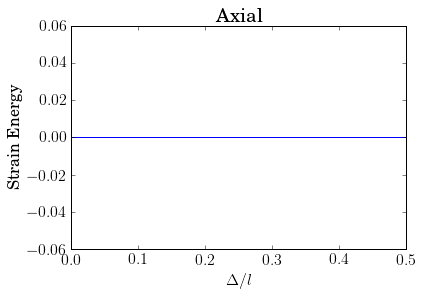

In [26]:
plt.rc('text', usetex=True)
plt.plot(delta/0.12, Ul_theta)
plt.title('Axial')
plt.ylabel('Strain Energy')
plt.xlabel('$\Delta/l$')
plt.show()

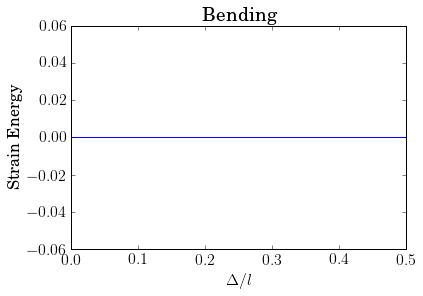

In [27]:
plt.rc('text', usetex=True)
plt.plot(delta/0.12, Ut_theta)
plt.title('Bending')
plt.ylabel('Strain Energy')
plt.xlabel('$\Delta/l$')
plt.show()

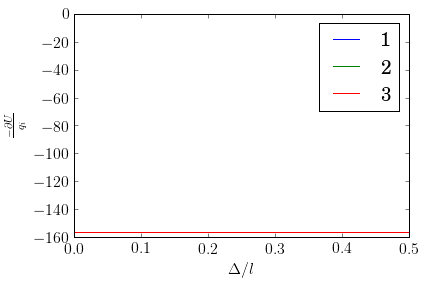

In [28]:
plt.rc('text', usetex=True)
for i in range(3):
    plt.plot(delta/0.12, beta_theta[:,i])
plt.ylabel(r'$\frac{ - \partial U}{q_i}$')
plt.xlabel('$\Delta/l$')
plt.legend(['1','2','3','4','5','6'])
plt.show()

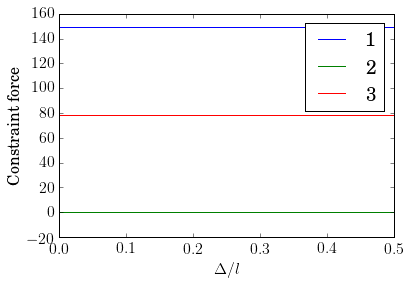

In [29]:
plt.rc('text', usetex=True)
for i in range(3):
    plt.plot(delta/0.12, F1c[:,i])
plt.ylabel('Constraint force')
plt.xlabel('$\Delta/l$')
plt.legend(['1', '2', '3'])
plt.show()

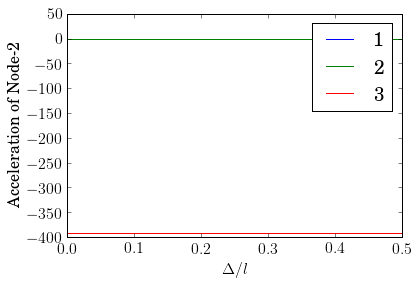

In [30]:
plt.rc('text', usetex=True)
for i in range(3):
    plt.plot(delta/0.12, A2[:,i])
plt.ylabel('Acceleration of Node-2')
plt.xlabel('$\Delta/l$')
plt.legend(['1', '2', '3'])
plt.show()

In [31]:
M_num     =  M_func(   0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 
                    g_num, 3.14, q0GEBF[0], np.zeros_like(theta), np.zeros_like(omega))
beta_num  =  beta_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 
                    g_num, 3.14, q0GEBF[0], np.zeros_like(theta), np.zeros_like(omega))        
Gamma1_num = Gamma1_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 
                    g_num, 3.14, q0GEBF[0], np.zeros_like(theta), np.zeros_like(omega))
Gamma2_num = Gamma2_func(0.7e6, 0.0018, 1.215e-8, 0.02393, 5540, 0.12, 
                    g_num, 3.14, q0GEBF[0], np.zeros_like(theta), np.zeros_like(omega))

M11 = np.array(M_num[0:3,0:3])
M12 = np.array(M_num[0:3,3:6])
M21 = np.array(M_num[3:6,0:3])
M22 = np.array(M_num[3:6,3:6])

# For now use these definitions to cast Fic (constraint forces between GEBF elements) 
# into generalized constraint forces
gamma11 = Gamma1_num[0:3,:]
gamma12 = Gamma1_num[3:6,:]
gamma21 = Gamma2_num[0:3,:]
gamma22 = Gamma2_num[3:6,:]


# partition beta into lambda13 and lambda23
gamma13 = np.array(beta_num[0:3])
gamma23 = np.array(beta_num[3:6])

# Commonly inverted quantities
iM11 = np.linalg.inv(M11)
iM22 = np.linalg.inv(M22)
Chi1 = np.linalg.inv(M11 - M12.dot(iM22.dot(M21)))
Chi2 = np.linalg.inv(M22 - M21.dot(iM11.dot(M12)))

# Compute all terms of the two handle equations
z11 = Chi1.dot(gamma11 - M12.dot(iM22.dot(gamma21)))
z12 = Chi1.dot(gamma12 - M12.dot(iM22.dot(gamma22)))
z21 = Chi2.dot(gamma21 - M21.dot(iM11.dot(gamma11)))
z22 = Chi2.dot(gamma22 - M21.dot(iM11.dot(gamma12)))

z13 = Chi1.dot(gamma13 - M12.dot(iM22.dot(gamma23))).reshape((3,1))
z23 = Chi2.dot(gamma23 - M21.dot(iM11.dot(gamma13))).reshape((3,1))

# Cantilever conditions
# fix node one, D = eye, P = zeros, and let node two be free 
F1c = -np.linalg.inv(z11).dot(z13)
A2 = np.dot(z21,F1c) + z23

#     # Free-Free conditions
#     A1 = z13
#     A2 = z23

In [42]:
np.linalg.inv(z11)

matrix([[ 0.0001, -0.0048,  0.5705],
        [-0.0048,  0.2988, -0.    ],
        [ 0.    ,  0.    ,  0.2988]])

In [33]:
# np.linalg.inv(M_num)*beta_num

In [34]:
# np.linalg.inv(z11).dot(-z13)

In [35]:
# np.linalg.inv(z11)

In [36]:
# np.dot(z21,np.linalg.inv(z11).dot(-z13)) + z23

In [37]:
# # print('\nM = \n')
# # display(M)

# # print('M_11 = ')
# # display(M[0:3,0:3])
# # print('\nM_22 = ')
# # display(M[3:6,3:6])
# # print('\nM_12 = ')
# # display(M[0:3,3:6])
# # print('\nM_21.T = ')
# # display(M[3:6,0:3].T)

# # sym.Rational(1,2)*sym.factor(sym.expand(M).subs([('theta_1',0),('theta_2',0), (rho*r*l,m)]))
# sym.Rational(1,2)*sym.factor(sym.expand(M).subs([(rho*r*l,m)]))
# # M.subs([('theta_1',0),('theta_2',0)])

In [38]:
# # TEST
# r, R, beta, pi= sym.symbols('r,R,beta,pi')
# s = sym.Matrix(['r_1','r_2','r_3'])
# s[0] = 0

# s_skew = sym.Matrix([[0,-s[2], s[1]],[s[2],0,-s[0]],[-s[1],s[0],0]])

# m = sym.integrate(rho*pi,('r_2',0,R),('r_3',0,R))
# eta = 1/m*sym.integrate(rho*pi*s, ('r_2',0,R),('r_3',0,R))
# sigma = sym.integrate(rho*pi*s_skew*s_skew.T, ('r_2',0,R),('r_3',0,R))
# eta_skew = sym.Matrix([[0,-s[2], s[1]],[s[2],0,-s[0]],[-s[1],s[0],0]])


# M_slice = sym.Matrix.vstack(sym.Matrix.hstack(sigma, m*eta_skew),
#                             sym.Matrix.hstack(m*eta_skew.T, m*sym.eye(3)))

# N = sym.Matrix.vstack(sym.Matrix.vstack(sym.Matrix.hstack(h[0]*sym.eye(3), sym.zeros(3)),
#                                         sym.Matrix.hstack(sym.zeros(3), h[0]*sym.eye(3))),
#                       sym.Matrix.vstack(sym.Matrix.hstack(h[1]*sym.eye(3), sym.zeros(3)),
#                                         sym.Matrix.hstack(sym.zeros(3), h[1]*sym.eye(3))))

# M_test = sym.integrate(N*M_slice*N.T, (x,0,l))
# sym.expand(M_test)
# # # .subs([(pi*R**2,A),(rho*A*l,m)])      

In [39]:
# M.subs([(theta[0],0),(theta[1],0)])

In [40]:
z11

matrix([[ 105181.9076,    1678.002 , -200796.4353],
        [   1678.002 ,      30.1159,   -3203.3725],
        [      0.    ,       0.    ,       3.3462]])

In [41]:
Gamma2_num

matrix([[ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 1.   , -0.   ,  1.909],
        [ 0.   ,  1.   ,  0.   ],
        [ 0.   ,  0.   ,  1.   ]])